# Dogs and Cats

<img src='https://images.pexels.com/photos/1909802/pexels-photo-1909802.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260' style="height: 400px;">

Photo by [Sharon McCutcheon](https://www.pexels.com/@mccutcheon)

## Context

* Type : Computer Vision (use of CNN)
* Dataset : refer to [this Kaggle's competition](https://www.kaggle.com/c/dogs-vs-cats)

## Goal 
Classify whether images contain either a dog or a cat. 

---

In [1]:
import os, re, random
import numpy as np
import pandas as pd                       # only for the creation of a csv submission file

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Data Preparation

First, we've to retrieve sorted lists of all image files in both the train & test directories

In [3]:
train_dir = '../input/train/'
test_dir = '../input/test/'

# list of all img files for both train & test dataset
train_img = [train_dir + i for i in os.listdir(train_dir)]
test_img  = [test_dir  + i for i in os.listdir(test_dir)]

The train folder contains 25,000 images of dogs and cats. Each image in this folder has the label as part of the filename. The test folder contains 12,500 images, named according to a numeric id. For each image in the test set, you should predict a probability that the image is a dog (1 = dog, 0 = cat).

In [4]:
train_img_nb, test_img_nb = len(train_img), len(test_img)
print('train images nb:', train_img_nb, 'vs test images nb:', test_img_nb)

train images nb: 25000 vs test images nb: 12500


Take a look at the first and last images, they are in color (so channel = 3 unlike black/white ones where channel = 1) and the size seems to be same but we never know (not tested for each element). Visualization of other few images choosen randomly :

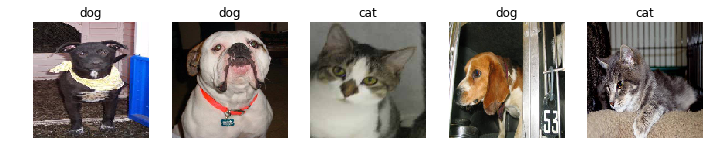

In [5]:
img_width, img_height, channels = 150, 150, 3

# display 5 randomly choosen images
plt.figure(figsize=(12, 5))

for i in range(1, 6):
    plt.subplot(1, 5, i)
    num = random.randint(0, train_img_nb)
    plt.imshow(load_img(train_img[num], target_size=(img_width, img_height)))
    plt.axis('off')
    plt.title('cat')
    if 'dog' in train_img[num]:
        plt.title('dog')

plt.show()

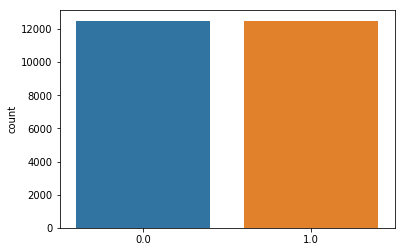

In [6]:
y = np.zeros(shape=[train_img_nb])

for i in range(0, train_img_nb):
    if 'dog' in train_img[i]:
        y[i] = 1

sns.countplot(y)

The two classes have the same nb of images for both categories and therefore are balanced.

Now let's put each image of the train samples in a folder corresponding to its class

In [7]:
# create two specific dirs
os.mkdir('../input/train/cats')
os.mkdir('../input/train/dogs')

In [8]:
# move each file depending on the string in the file name
for img in os.listdir(train_dir):
    if img == 'cats' or img == 'dogs':
        continue
    if 'cat' in img:
        os.rename(train_dir + img, '../input/train/cats/' + img)
    else:
        os.rename(train_dir + img, '../input/train/dogs/' + img)

Last, we've to split the train data set into 2 parts : a training set & a validation one. They will be used later to compute the accuracy and loss on the validation set while fitting the model using training set.

In [9]:
batch_size = 32

# augmentation configuration used for training
data_generator = ImageDataGenerator(
                        rescale=1./255,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=False,
                        validation_split=0.2)


# generator that will read pictures found in subfolders, and generate batches of augmented image data
train_generator = data_generator.flow_from_directory(
                        directory = train_dir,
                        target_size = (img_width, img_height),
                        batch_size = batch_size,
                        class_mode = 'binary',    # because we've only 2 classes
                        subset = 'training')      # the training / 

val_generator = data_generator.flow_from_directory(
                        directory = train_dir,
                        target_size = (img_width, img_height),
                        class_mode = 'binary',
                        subset = 'validation')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


----

# Model Evaluation

We're going to build a Convolutional Neural Network (CNN).

## Theory
Summary from this source : [towardsdatascience@_sumitsaha_](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) 
<img src='https://cdn-images-1.medium.com/max/1800/1*vkQ0hXDaQv57sALXAJquxA.jpeg' style="height: 200px;">
A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.

A ConvNet is able __to successfully capture the Spatial and Temporal dependencies in an image__ through the application of relevant filters. The architecture performs a better fitting to the image dataset due to the reduction in the number of parameters involved and reusability of weights. In other words, the network can be trained to understand the sophistication of the image better.

A CNN is sequence of convolution layers pooling layers between, finished by a fully connected layer.

<img src='https://cdn-images-1.medium.com/max/900/1*15yDvGKV47a0nkf5qLKOOQ.png' style="height: 200px;">
 The role of the ConvNet is to reduce the RGB images into a form which is easier to process, without losing features which are critical for getting a good prediction.
 
__Convolution Layer — The Kernel__
 <img src='https://cdn-images-1.medium.com/max/1200/1*ciDgQEjViWLnCbmX-EeSrA.gif' style="height: 200px;">
 The filter or kernel moves to the right with a certain Stride Value till it parses the complete width. Moving on, it hops down to the beginning (left) of the image with the same Stride Value and repeats the process until the entire image is traversed.

<img src='https://cdn-images-1.medium.com/max/900/1*nYf_cUIHFEWU1JXGwnz-Ig.gif' style="height: 200px;">

 The objective of the Convolution Operation is to extract the high-level features such as edges, from the input image. ConvNets need not be limited to only one Convolutional Layer. Conventionally, the first ConvLayer is responsible for capturing the Low-Level features such as edges, color, gradient orientation, etc. With added layers, the architecture adapts to the High-Level features as well, giving us a network which has the wholesome understanding of images in the dataset, similar to how we would.
 
 __Pooling Layer__
 
 <img src='https://cdn-images-1.medium.com/max/900/1*nYf_cUIHFEWU1JXGwnz-Ig.gif' style="height: 200px;">
 
 Similar to the Convolutional Layer, the Pooling layer is responsible for reducing the spatial size of the Convolved Feature. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features which are rotational and positional invariant, thus maintaining the process of effectively training of the model.
 
  <img src='https://cdn-images-1.medium.com/max/900/1*uoWYsCV5vBU8SHFPAPao-w.gif' style="height: 200px;">
  
  __Classification — Fully Connected Layer__
  
 Adding a Fully-Connected layer is a (usually) cheap way of learning non-linear combinations of the high-level features as represented by the output of the convolutional layer. The Fully-Connected layer is learning a possibly non-linear function in that space.

  <img src='https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/35_blog_image_27.png' style="height: 200px;">

Now that we have converted our input image into a suitable form for our Multi-Level Perceptron, we shall flatten the image into a column vector. The flattened output is fed to a feed-forward neural network and backpropagation applied to every iteration of training. Over a series of epochs, the model is able to distinguish between dominating and certain low-level features in images and classify them using the Softmax Classification technique in case of mutiple class. Here we'll use the sigmoid activation function for a binray classification task.

## Model architecture

In [10]:
def create_model():
    
    model = Sequential()

    # Layer C1
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(img_width, img_height, channels)))
    # Layer S2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Layer C3
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    # Layer S4
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Before going into layer C5, we flatten our units
    model.add(Flatten())
    # Layer C5
    model.add(Dense(units=120, activation='relu'))
    # Layer F6
    model.add(Dense(units=84, activation='relu'))
    # Output layer
    model.add(Dense(units=1, activation = 'sigmoid'))
    
    return model

In [11]:
model = create_model()
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 6)       168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 16)        880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0         
_________________________________________________________________
dense (Dense)                (None, 120)               2488440   
_________________________________________________________________
dens

In [12]:
# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Define the callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
            TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]

> ## Model training

Since data is huge and might not fit in your computer memory, use keras `ImageDataGenerator` and `fit_generator` to train your model on the data. This is a case where the `fit_generator` becomes really useful.

In [13]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch = 20000 // batch_size,
        epochs = 12,
        validation_data = val_generator,
        validation_steps = 5000 // batch_size,
        callbacks = callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/12
625/625 [==============================] - 184s 295ms/step - loss: 0.6177 - acc: 0.6617 - val_loss: 0.5451 - val_acc: 0.7242
Epoch 2/12
625/625 [==============================] - 198s 316ms/step - loss: 0.5373 - acc: 0.7325 - val_loss: 0.5100 - val_acc: 0.7544
Epoch 3/12
625/625 [==============================] - 201s 322ms/step - loss: 0.4919 - acc: 0.7629 - val_loss: 0.4871 - val_acc: 0.7746
Epoch 4/12
625/625 [==============================] - 205s 328ms/step - loss: 0.4612 - acc: 0.7851 - val_loss: 0.5015 - val_acc: 0.7664
Epoch 5/12
625/625 [==============================] - 195s 311ms/step - loss: 0.4361 - acc: 0.7997 - val_loss: 0.4761 - val_acc: 0.7772
Epoch 6/12
625/625 [==============================] - 190s 305ms/step - loss: 0.4160 - acc: 0.8137 - val_loss: 0.4512 - val_acc: 0.7938
Epoch 7/12
625/625 [==============================] - 192s 307ms/step - loss: 0.4002 - acc: 0.8205 - val_loss: 0.4915 - val_acc: 0.7764


In [14]:
# saving model and it's weights
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

## Performances estimation & Training Metrics

After several tries, i've changed a little bit the architecture of the model (the number of layers and/or the number of units), the hyperparameters, and used data augmentation in order to improve the results. When it comes to estimate this model's performances, we can see that:
* the loss has decreased from 0.58 to 0.31
* the accuracy has increased from 0.68 to 0.86, while the accuracy on the validation dataset has changed from 0.72 to 0.81. This mean that the model has learnt and is able to generalize on another dataset.

One of the default callbacks that is registered when training all deep learning models is the History callback. It records training metrics (training accuracy, training loss, validation loss & validation accuracy) for each epoch. Note that training accuracy & loss during epoch steps are somewhat incomplete information and they are not recorded in history.

Observe that training uses early stopping, hence metrics is available for epochs run, not for the set param of epochs nb.

In [15]:
print(fit_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


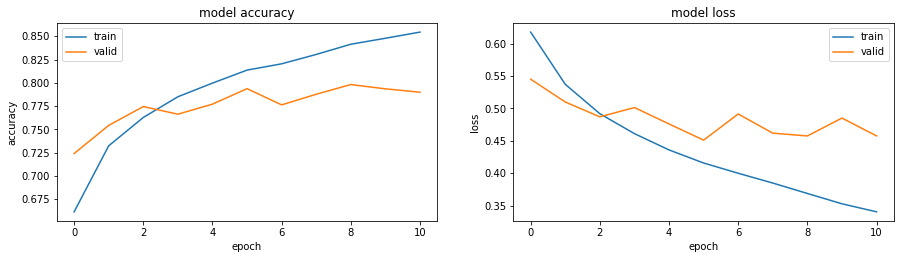

In [16]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

# Prediction & submission

In [25]:
# create two specific dirs
os.mkdir('../input/test/oneclass')

# move all files
for img in os.listdir(test_dir):
    if img == 'oneclass':
        continue
    os.rename(test_dir + img, '../input/test/oneclass/' + img)

In [26]:
# flow_from_directory treats each sub-folder as a class which works fine for training data
# but for the test set that's not the case, here's a workaround:
#    - dataset is kept in a single subfolder of test
#    - use the param class_mode=None is a kind of 


# generator that will read pictures found a generate batches of augmented image data -- batch_size can be 1 or 
# any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = data_generator.flow_from_directory(
    directory = test_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,  # we don't have label here, that's what we want to predict
)

Found 12500 images belonging to 1 classes.


In [27]:
# Reset before each call to predict
test_generator.reset()
pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)

391/391 [==============================] - 70s 179ms/step


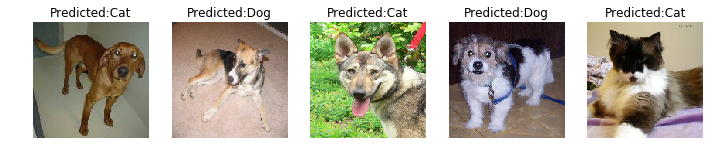

In [28]:
# display 5 randomly choosen images with the predicted labels
plt.figure(figsize=(12, 5))

for i in range(1, 6):
    plt.subplot(1, 5, i)
    num = random.randint(0, test_img_nb)
    plt.imshow(load_img(test_dir + test_generator.filenames[num], target_size=(img_width, img_height)))
    predicted_class = 'Dog' if pred[num] >= 0.5 else 'Cat'
    plt.title(f"Predicted:{predicted_class}")
    plt.axis('off')

plt.show()

In [29]:
df_submission = pd.DataFrame(
    {
        'id': pd.Series(test_generator.filenames), 
        'label': pd.Series(predicted_class_indices)
    })
df_submission['id'] = df_submission.id.str.extract('(\d+)')
df_submission['id'] = pd.to_numeric(df_submission['id'], errors = 'coerce')
df_submission.sort_values(by='id', inplace = True)

df_submission.to_csv('submission.csv', index=False)
df_submission.head()

,id,label
0,1,0
3612,2,0
4723,3,0
5834,4,0
6945,5,0
